In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

We'll use the MNIST Handwritten Digit Recognition Dataset as a running example. Below, we are creating a training and testing split, which we've done before.

In [2]:
# Load data from https://www.openml.org/d/554
# MNIST has 70000 samples, each having 28x28 resolution
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype(np.float32)/255
y = y.astype(np.int32)
# Data has been fetched as a Dataframe, but we will need them as np arrays, so lets convert
# Pandas use the loc attribute to return one or more specified row(s)
print(X.loc[8])
X = np.array(X.loc[:])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 8, Length: 784, dtype: float32
(56000, 784)
(14000, 784)


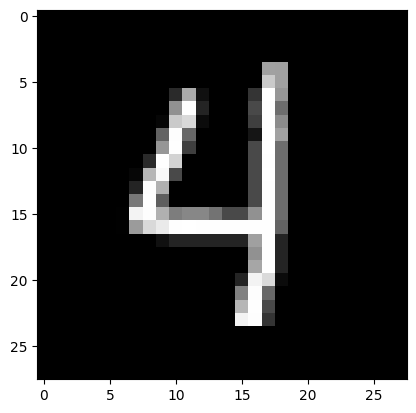

In [5]:
# Below code is to show an example handwritten character.
plt.imshow(X_train[7,:].reshape(28,28),cmap='gray')

We will use PyTorch framework for this lecture, but there are other NN frameworks available for Python (such as Tensorflow-Keras).


In [4]:
import torch
from torch import nn
import torch.utils.data

First, we need to get the data in a form that PyTorch likes to use it. It has its own concept of a "DataSet", as well as a "DataLoader". For a problem as small as MNIST, this is a little over-kill. But when working with datasets that are larger than your computer's RAM, its a necessity! Neural Networks tend to work best when you have lots of data, so this is a pretty common use case.

PyTorch also has its own concept of a *tensor*. This is *very* similar to our numpy arrays that we have been working with. The difference is PyTorch uses its tensors to store extra information for performing automatic differentiation in an efficent manner, and information needed for things like using GPUs.

In [7]:
#The 'TensorDataset' class in pyTorch is for working with smaller datasets that can fit in memory, like ours!
mnist_train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
mnist_test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [8]:
#When training a neural network, we will operate in "batches"
#If our data has N total rows and batch size=64, then we have N/64 total batches of the data that we can take.
#Gradient updates are done after each batch, instead of waiting to see whole data
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

In [9]:
N = len(mnist_train_dataset) #Number of training points
d = X.shape[1] #Number of features
C =  np.max(y_train)+1 #Number of classes
print(N, d, C)

56000 784 10


Because modern deep learning is about using building blocks to build something larger, let's talk about our first building block. A linear transform. We've already seen this a number of times.

Say we have some input $x \in \mathbb{R}^d$, and we want to do binary logistic regression, we get a weight vector $w$ and compute $x^T w$. When we have $C$ total classes, we create $C$ weight vectors $w^{(1)}, w^{(2)}, \ldots, w^{(C)}$. Its more efficent to store all $C$ vectors as a single matrix $W \in \mathbb{R}^{d, C}$. Then we can compute the result all at once as $\hat{y} = x^T W$.

So lets do that, using PyTorch.

In [3]:
model = torch.nn.Sequential(
          torch.nn.Linear(d, C),  #from 784 to 10, W is 784x10
          torch.nn.LogSoftmax(dim=1)
        )

NameError: name 'torch' is not defined

In [ ]:
#Done! That's the whole model! There are 784x10=7840 parameters in it.
#Lets train it now. We are going to use stochastic gradient descent.

loss_fn = nn.NLLLoss()  #The negative log likelihood loss OR Softmax loss as we know it
#loss_fn = nn.CrossEntropyLoss() #CrossEntropy is the loss we used for Logistic Regression

#We need an optimizer! Adam is a good default one that works "well enough" for most problems
#To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
optimizer = torch.optim.Adam(model.parameters())

lossbyepoch=[]

for epoch in range(20):
  running_loss = 0.0

  for inputs, labels in train_loader: #for each batch

    # zero the parameter gradients at the beginning of each batch
    optimizer.zero_grad()

    # get the prediction with current parameters (weights)
    y_pred = model(inputs)

    # Compute loss.
    loss = loss_fn(y_pred, labels.long())

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    if epoch==0:
      print(loss.item())

  lossbyepoch.append(running_loss)

  print("Loss on epoch {} is {}".format(epoch, running_loss))

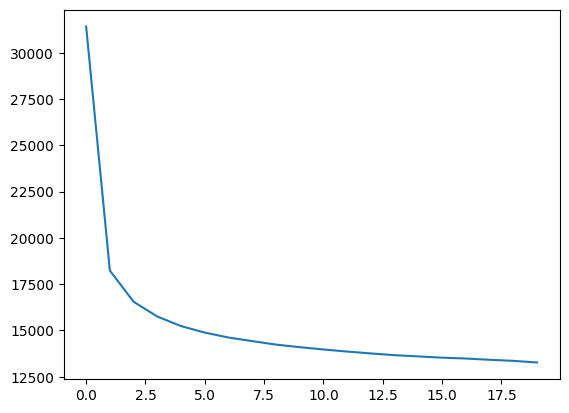

In [13]:
# Plot the points using matplotlib
x = np.arange(0, 20, 1)
plt.plot(x, lossbyepoch)

In [14]:
model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

predictions = []
targets = []

for inputs, labels in test_loader:    # now we feed test data with test_loader
  y_pred = model(inputs)

  # Get predicted classes
  # y_pred will have a shape (Batch_size, C)
  #We are asking for which class had the largest response along dimension #1, the C dimension
  for pred in torch.argmax(y_pred, dim=1).numpy():
    predictions.append(pred)
  for l in labels.numpy():
    targets.append(l)

print("Network Accuracy: ", accuracy_score(predictions, targets))

Network Accuracy:  0.924


Code is working well! One thing we can do to make life easier though, is to wrap up some of this code into some re-usable functionality. Let's go ahead and do that, and also add a change to the compute *device*. By default we are using the CPU, but PyTorch can leverage a GPU as well. And colab will let us use a GPU for free if we ask nice!

Also we add regularization loss, and some code to monitor the accuracy on the training and on the validation data (after each epoch).

In [15]:
def train_log_loss_network(model, lossbyepoch, train_loader, val_loader=None, epochs=50, device="cpu"):

  #Like before, we phrase learning as minimize a loss function. This is the loss we are going to minimize!
  loss_fn = nn.NLLLoss()  #The negative log likelihood loss OR Softmax loss as we know it
  #loss_fn = nn.CrossEntropyLoss() #CrossEntropy is another name for the Logistic Regression loss function.

  #We need an optimizer! Adam is a good default one that works "well enough" for most problems
  #To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  #optimizer = torch.optim.Adam(model.parameters())
  #Other options for an optimizer:
  ##optimizer = torch.optim.Adagrad(model.parameters())
  ##optimizer = torch.optim.RMSprop(model.parameters())
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  #Devices can be specified by a string, or a special torch object
  #If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

  model.to(device)#Place the model on the correct compute resource

  for epoch in range(epochs):

    model = model.train()#Put our model in training mode
    running_loss = 0.0
    predictions = []
    targets = []

    for inputs, labels in train_loader: #tqdm(train_loader):

      #Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute data loss:
      data_loss = loss_fn(y_pred, labels.long())

      # Regularization loss:
      ##Replace pow(2.0) with abs() for L1 regularization
      l2_lambda = 0.0001 #regularization strength
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
      l2_loss = l2_lambda * l2_norm

      # Total loss = data loss + regularization loss
      loss = data_loss + l2_loss

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)

      # Get predicted classes
      # y_pred will have a shape (Batch_size, C)
      #We are asking for which class had the largest response along dimension #1, the C dimension
      for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
        predictions.append(pred)
      for l in labels.cpu().numpy():
        targets.append(l)

    #If you want to print training set accuracy
    #print("Train accuracy: {}".format(accuracy_score(predictions, targets)))

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else:#Lets find out validation performance as we go!
      model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

      predictions = []
      targets = []

      for inputs, labels in val_loader:

        #Move the batch to the device we are using.
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        #We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        for l in labels.cpu().numpy():
          targets.append(l)

      print("Loss after epoch {} is {}. Test accuracy: {}".format(epoch, running_loss, accuracy_score(predictions, targets)))

      lossbyepoch.append(running_loss) # to be used for plotting purposes

In [16]:
lossbyepoch=[]
#If we call this now, it will continue from our already trained model. So not too much will happen
train_log_loss_network(model, lossbyepoch, train_loader, val_loader=test_loader, epochs=15)
#train_log_loss_network(model, train_loader)  #this works with defaults: val_loader=None, epochs=50

Loss after epoch 0 is 22738.55170249939. Test accuracy: 0.9241428571428572
Loss after epoch 1 is 22434.798893928528. Test accuracy: 0.9245
Loss after epoch 2 is 22138.352739334106. Test accuracy: 0.9246428571428571
Loss after epoch 3 is 21891.4069814682. Test accuracy: 0.9237857142857143
Loss after epoch 4 is 21630.45308494568. Test accuracy: 0.9245
Loss after epoch 5 is 21395.464029312134. Test accuracy: 0.9237857142857143
Loss after epoch 6 is 21180.916345596313. Test accuracy: 0.9242857142857143
Loss after epoch 7 is 20943.955605506897. Test accuracy: 0.9252142857142858
Loss after epoch 8 is 20758.489659309387. Test accuracy: 0.9245
Loss after epoch 9 is 20538.667278289795. Test accuracy: 0.9240714285714285
Loss after epoch 10 is 20349.4395942688. Test accuracy: 0.9242857142857143
Loss after epoch 11 is 20170.40434741974. Test accuracy: 0.9255714285714286
Loss after epoch 12 is 19987.480107307434. Test accuracy: 0.9238571428571428
Loss after epoch 13 is 19822.62005996704. Test accur

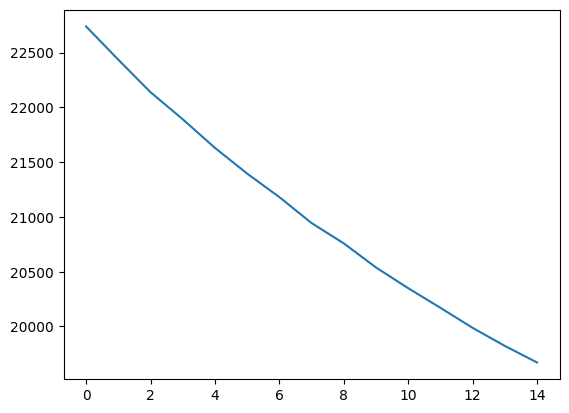

In [17]:
# Plot the points using matplotlib
x = np.arange(0, len(lossbyepoch), 1)
plt.plot(x, lossbyepoch)

Ok, re-implementing a linear layer was nice. Most of the work went into the framework around learning. Let's summarize what happened from a math perspective.

We defined a model $f(x)$, and a loss function $ L(x, y)$. In this case, $f(x) = x^T W$ was a pretty simple model, and $L$ is the standard cross-entropy/logistic loss. We did this using Adam, which took care of learning rate $\alpha$ for us.

### Our first deep neural network
We will start by defining a simple *fully-connected* neural network. It's called fully-connected because each neuron of the network will have a connection to the neurons on the next layer.

Lets start with what is called one *hidden* layer. The input $x$ is consider the "input layer", and the $\mathbb{R}^C$ dimensional output is considerd the "output-layer".

How do we do that? Well, the easiest option would be to stick another matrix in there. So instead of

$$f(x) = x^T W_{d \times C}$$

we will put something like

$$f(x) = x^T W^{(h_1)}_{d \times n} W^{(\text{out})}_{n \times C}$$

Notice this new value $n$ of the matrix dimension. Its a new hyper-parameter for us to tune and deal with. It is called the "hidden layer size", or often the "number of neurons" in the first hidden layer.

In [18]:
n = 300
model = torch.nn.Sequential(
  torch.nn.Linear(d, n),  # 784x300
  torch.nn.Linear(n, C),  # 300x10
  torch.nn.LogSoftmax(dim=1)
)

In [19]:
lossbyepoch=[]
train_log_loss_network(model, lossbyepoch, train_loader, val_loader=test_loader, epochs=20)

Loss after epoch 0 is 26119.89156961441. Test accuracy: 0.9115714285714286
Loss after epoch 1 is 17949.637463092804. Test accuracy: 0.9142857142857143
Loss after epoch 2 is 17145.930463314056. Test accuracy: 0.9135
Loss after epoch 3 is 16771.799649715424. Test accuracy: 0.9172142857142858
Loss after epoch 4 is 16459.77658557892. Test accuracy: 0.9152857142857143
Loss after epoch 5 is 16306.748404026031. Test accuracy: 0.9182857142857143
Loss after epoch 6 is 16084.153971672058. Test accuracy: 0.9175
Loss after epoch 7 is 15980.347353458405. Test accuracy: 0.9210714285714285
Loss after epoch 8 is 15917.152997016907. Test accuracy: 0.9173571428571429
Loss after epoch 9 is 15802.79250574112. Test accuracy: 0.9208571428571428
Loss after epoch 10 is 15678.313422203064. Test accuracy: 0.9151428571428571
Loss after epoch 11 is 15622.858106136322. Test accuracy: 0.9174285714285715
Loss after epoch 12 is 15522.434946537018. Test accuracy: 0.9184285714285715
Loss after epoch 13 is 15488.2128920

So, we made our model more sophisticated but it did about the same. A little bit of linear algebra will answer why this happened. Weights in

$$f(x) = x^T W^{(h_1)}_{d \times n} W^{(\text{out})}_{n \times C}$$

are a simple multiplication of two matrices, which means

$$W^{(h_1)}_{d \times n} W^{(\text{out})}_{n \times C} = \tilde{W}_{d, c}$$

and therefore

$$f(x) = x^T W^{(h_1)}_{d \times n} W^{(\text{out})}_{n \times C} = x^T \tilde{W}_{d, c}$$

That's equivalent to the original linear model we started with!

In order to get any kind of benefit, we will need to introduce some kind of *non-linearity* between every step. Lets use $\sigma(x)$ to denote some simple element-wise function:

$$f(x) = \sigma(x^T W^{(h_1)}_{d \times n}) W^{(\text{out})}_{n \times C} $$

The choices for $\sigma(x)$ non-linearity are *sigmoid*, *tanh*, *ReLU* and many more.

Let's add non-linearity to our model.

In [20]:
n = 300
model = torch.nn.Sequential(
  torch.nn.Linear(d, n),
  torch.nn.ReLU(),
  torch.nn.Linear(n, C),
  torch.nn.LogSoftmax(dim=1)
)

We can also improve on the speed by leveraging a GPU. The below code is a safe way to check for a GPU being available, and then using it.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
lossbyepoch=[]
train_log_loss_network(model, lossbyepoch, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 26866.42183828354. Test accuracy: 0.9248571428571428
Loss after epoch 1 is 13675.58303642273. Test accuracy: 0.9414285714285714
Loss after epoch 2 is 10560.904600143433. Test accuracy: 0.9545714285714286
Loss after epoch 3 is 8741.455003023148. Test accuracy: 0.9599285714285715
Loss after epoch 4 is 7541.790558815002. Test accuracy: 0.9642142857142857
Loss after epoch 5 is 6753.359003782272. Test accuracy: 0.9680714285714286
Loss after epoch 6 is 6130.761312484741. Test accuracy: 0.9682857142857143
Loss after epoch 7 is 5682.957918405533. Test accuracy: 0.9704285714285714
Loss after epoch 8 is 5307.094022274017. Test accuracy: 0.9709285714285715
Loss after epoch 9 is 5032.4683430194855. Test accuracy: 0.9721428571428572
Loss after epoch 10 is 4809.503197193146. Test accuracy: 0.9725
Loss after epoch 11 is 4613.000013113022. Test accuracy: 0.9723571428571428
Loss after epoch 12 is 4432.363421678543. Test accuracy: 0.9735714285714285
Loss after epoch 13 is 4288.2871

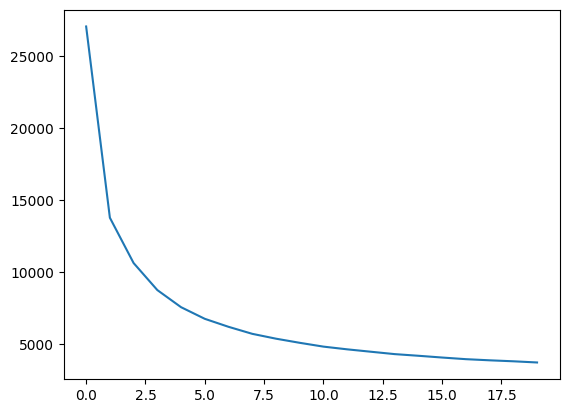

In [33]:
# Plot the points using matplotlib
x = np.arange(0, len(lossbyepoch), 1)
plt.plot(x, lossbyepoch)

Now we are getting somewhere! That was a big improvement in accuracy!

Let's also talk about different options for Pytorch optimizer:

You need go up and change the ralted line in <code>train_log_loss_network</code>

In [ ]:
help(torch.optim.SGD) #we have to define lr  #defaults: momentum=0, dampening=0, weight_decay=0, nesterov=False

In [ ]:
help(torch.optim.Adagrad) #defaults: lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10

In [ ]:
help(torch.optim.RMSprop)  #defaults:  lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0,

In [ ]:
help(torch.optim.Adam)   #defaults: lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0

We can also change regularization strength for L2 regularization loss (in  <code>train_log_loss_network</code>).

For this dataset its effectiveness is limited. But soon enough we will see another regularization technique called ***dropout***.

As we add more layers, the model is getting more complicated

Two hidden layers:
$$f(x) = \sigma(\sigma(x^T W^{(h_1)}) W^{(h_2)}) W^{(\text{out})} $$

Three hidden layers:
$$f(x) = \sigma(\sigma(\sigma(x^T W^{(h_1)}) W^{(h_2)})  W^{(h_3)} )W^{(\text{out})} $$


In [34]:
n = d*2
model = torch.nn.Sequential(
  #First hidden layer
  torch.nn.Linear(d, n),
  torch.nn.ReLU(),
  #Second
  torch.nn.Linear(n, n),
  torch.nn.ReLU(),
  #Third
  torch.nn.Linear(n, n),
  torch.nn.ReLU(),
  #Fourth
  torch.nn.Linear(n, n),
  torch.nn.ReLU(),
  #Output!
  torch.nn.Linear(n, C),
  torch.nn.LogSoftmax(dim=1)
)
train_log_loss_network(model, lossbyepoch, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 50575.97958755493. Test accuracy: 0.9432857142857143
Loss after epoch 1 is 19702.156352996826. Test accuracy: 0.9665714285714285
Loss after epoch 2 is 16387.429293632507. Test accuracy: 0.9684285714285714
Loss after epoch 3 is 14614.432214736938. Test accuracy: 0.9645714285714285
Loss after epoch 4 is 13582.615216255188. Test accuracy: 0.975
Loss after epoch 5 is 12664.22893333435. Test accuracy: 0.977
Loss after epoch 6 is 11885.581374168396. Test accuracy: 0.9752142857142857
Loss after epoch 7 is 11256.296586036682. Test accuracy: 0.9789285714285715
Loss after epoch 8 is 10678.897859573364. Test accuracy: 0.9787142857142858
Loss after epoch 9 is 10235.963035583496. Test accuracy: 0.9775
Loss after epoch 10 is 9919.018633842468. Test accuracy: 0.9775
Loss after epoch 11 is 9510.086527824402. Test accuracy: 0.9788571428571429
Loss after epoch 12 is 9032.68448638916. Test accuracy: 0.9817857142857143
Loss after epoch 13 is 8680.14064693451. Test accuracy: 0.9817142

A little better... What we really need to make things fly is ***Batch-Normalization***. Batch-Norm does not increase a network's representional capacity, but it makes the learning faster and also it has a regularization effect.


In [ ]:
n = d*2
model2 = torch.nn.Sequential(
  #First hidden layer
  nn.Linear(d, n),
  nn.BatchNorm1d(n),
  nn.ReLU(),
  #Second
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.ReLU(),
  #Third
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.ReLU(),
  #Fourth
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.ReLU(),
  #Output!
  nn.Linear(n, C),
  nn.LogSoftmax(dim=1)
)
train_log_loss_network(model2, lossbyepoch, train_loader, val_loader=test_loader, epochs=20, device=device)


Loss after epoch 0 is 9886.108840346336. Test accuracy: 0.9731428571428572
Loss after epoch 1 is 3777.307606294751. Test accuracy: 0.9757857142857143
Loss after epoch 2 is 2371.0760841704905. Test accuracy: 0.9803571428571428
Loss after epoch 3 is 1399.024688847363. Test accuracy: 0.9815
Loss after epoch 4 is 1141.5201405640692. Test accuracy: 0.979
Loss after epoch 5 is 834.1326161012985. Test accuracy: 0.9802142857142857
Loss after epoch 6 is 708.0179102218244. Test accuracy: 0.9832142857142857
Loss after epoch 7 is 594.4823137961794. Test accuracy: 0.9840714285714286
Loss after epoch 8 is 450.25650981697254. Test accuracy: 0.9832142857142857
Loss after epoch 9 is 367.95702034328133. Test accuracy: 0.9840714285714286
Loss after epoch 10 is 264.47419108173926. Test accuracy: 0.9837142857142858
Loss after epoch 11 is 335.6219267930137. Test accuracy: 0.9845714285714285
Loss after epoch 12 is 288.5504885938717. Test accuracy: 0.9834285714285714
Loss after epoch 13 is 317.43344408040866.

You can also add the regularization technique called **Dropout**.

In [ ]:
n = d*2
model3 = torch.nn.Sequential(
  #First hidden layer
  nn.Linear(d, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Second
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Third
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Fourth
  nn.Linear(n, n),
  nn.BatchNorm1d(n),
  nn.Dropout(p=0.5),
  nn.ReLU(),
  #Output!
  nn.Linear(n, C),
  nn.LogSoftmax(dim=1)
)
train_log_loss_network(model3, lossbyepoch, train_loader, val_loader=test_loader, epochs=20, device=device)

Loss after epoch 0 is 21548.108812570572. Test accuracy: 0.9602142857142857
Loss after epoch 1 is 10756.107328474522. Test accuracy: 0.9701428571428572
Loss after epoch 2 is 8728.14609104395. Test accuracy: 0.9745714285714285
Loss after epoch 3 is 7568.264958202839. Test accuracy: 0.9752142857142857
Loss after epoch 4 is 6708.480403989553. Test accuracy: 0.9765714285714285
Loss after epoch 5 is 5891.721488818526. Test accuracy: 0.9768571428571429
Loss after epoch 6 is 5440.484969854355. Test accuracy: 0.9794285714285714
Loss after epoch 7 is 5049.251334905624. Test accuracy: 0.9797142857142858
Loss after epoch 8 is 4566.586777403951. Test accuracy: 0.9814285714285714
Loss after epoch 9 is 4401.723566491157. Test accuracy: 0.9797857142857143
Loss after epoch 10 is 4359.5780976861715. Test accuracy: 0.9825
Loss after epoch 11 is 3647.212943457067. Test accuracy: 0.9807857142857143
Loss after epoch 12 is 3611.9064619019628. Test accuracy: 0.9797142857142858
Loss after epoch 13 is 3500.083

### Congratulations!

### Next time: Convolutional Neural Networks!  